In [1]:
%matplotlib inline

In [3]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, Layout
from IPython.display import display
import seaborn as sns
from nilearn.input_data import NiftiMasker

In [4]:
in_dir = '/home/julia/projects/lc/processed/JH_20181214_rsfmri_test02/func/'
orig = nb.load('/home/julia/projects/lc/nifti/20181214_113919_JH_20181214_rsfmri_test02_1_1_nifti/JH20181214rsfmritest02/JH20181214rsfmritest02_45/JH20181214rsfmritest02_45.nii.gz')

In [5]:
orig_data = orig.get_data()

In [9]:
vol_to_remove = 25
mean_ts_before = np.average(orig_data, axis=(0,1,2))
mean_ts_after = np.average(orig_data[:,:,:,vol_to_remove:], axis=(0,1,2))

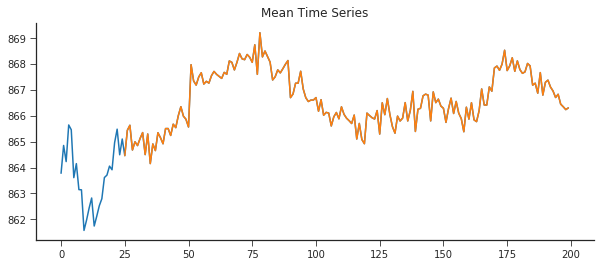

In [17]:
sns.set_style("ticks")
fig=plt.figure(figsize=(10,4))
plt.plot(mean_ts_before)
plt.plot(np.linspace(vol_to_remove, orig_data.shape[3]-1, orig_data.shape[3]-vol_to_remove), mean_ts_after)
plt.title("Mean Time Series")
sns.despine()

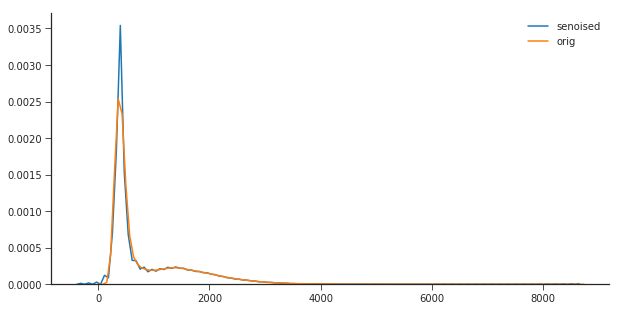

In [20]:
fig=plt.figure(figsize=(10,5))
sns.kdeplot(nb.load(in_dir+'func_moco.nii.gz').get_data().flatten(), label='denoised')
sns.kdeplot(orig_data[:,:,:,vol_to_remove:].flatten(), label='orig')
plt.legend()
sns.despine()

In [23]:
par_file = np.genfromtxt(in_dir + 'confounds/JH20181214rsfmritest02_45_roi_mp_denoised.nii.gz.par')

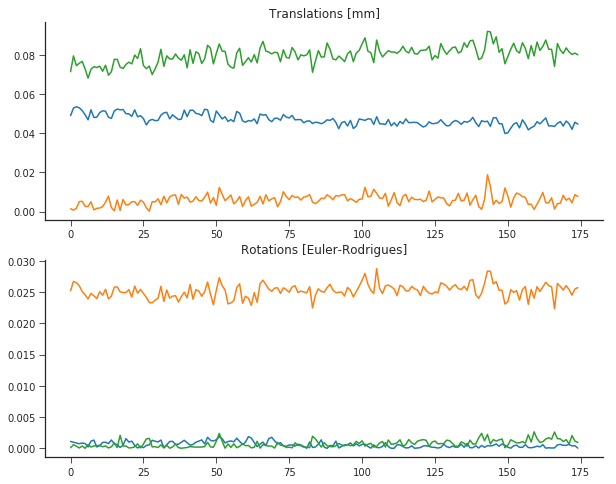

In [26]:
sns.set_style("ticks")
fig=plt.figure(figsize=(10,8))
fig.add_subplot(2,1,1)
for i in [0,1,2]:
    plt.plot(abs(par_file[:,i]))
    plt.title("Translations [mm]")
fig.add_subplot(2,1,2)
for i in [3,4,5]:
    plt.plot(abs(par_file[:,i]))
    plt.title("Rotations [Euler-Rodrigues]")
sns.despine()

In [14]:
norm_file = np.genfromtxt()

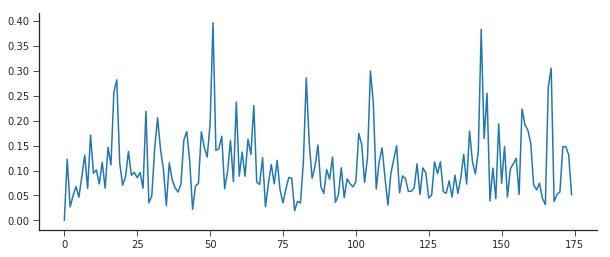

In [27]:
fig=plt.figure(figsize=(10,4))
plt.plot(norm_file)
sns.despine()

### Nuissance regression

In [32]:
norms=np.genfromtxt(in_dir + 'confounds/norm.func_moco.txt')
outliers=np.genfromtxt(in_dir + 'confounds/art.func_moco_outliers.txt')
intensity=np.genfromtxt(in_dir + 'confounds/global_intensity.func_moco.txt')

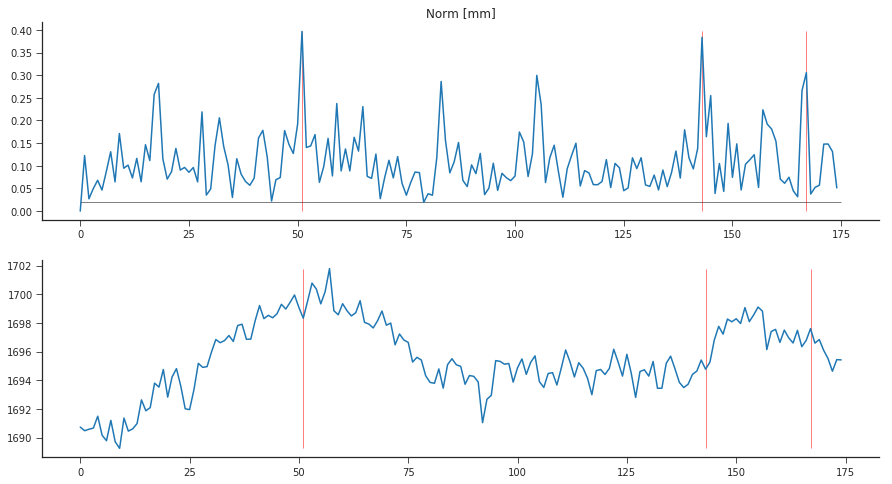

In [33]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
plt.plot(norms)
plt.hlines(0.02, 0, norms.shape[0], linewidth=0.5)
plt.vlines(outliers, norms.min(), norms.max(), linewidth=0.5, color='red')
plt.title("Norm [mm]")
fig.add_subplot(2,1,2)
plt.plot(intensity)
plt.vlines(outliers, intensity.min(), intensity.max(), linewidth=0.5, color='red')
sns.despine()

In [36]:
final = nb.load(in_dir+'func_final.nii.gz').get_data()
hdr = nb.load(in_dir+'func_moco.nii.gz').header
aff = nb.load(in_dir+'func_moco.nii.gz').affine

In [37]:
nb.save(nb.Nifti1Image(final, aff, hdr), in_dir+'func_final.nii.gz')

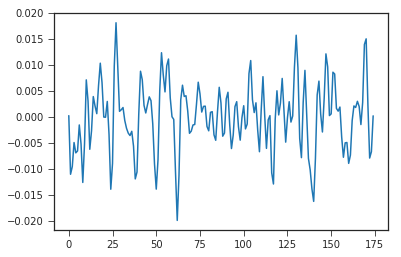

In [35]:
plt.plot(np.average(final, axis=(0,1,2)))

In [40]:
# create outlier regressors
outlier_file = arts.outputs.outlier_files
confound_len = norms.shape[0]
outlier_regressor = np.empty((confound_len,1))
try:
    outlier_val = np.genfromtxt(outlier_file)
except IOError:
    outlier_val = np.empty((0))
for index in np.atleast_1d(outlier_val):
    outlier_vector = np.zeros((confound_len, 1))
    outlier_vector[int(index)] = 1
    outlier_regressor = np.hstack((outlier_regressor, outlier_vector))
outlier_regressor = outlier_regressor[:,1::]

In [41]:
# calculate motion regressors
motreg_file = motion_regressors(out_dir+'func_moco_pars.txt', order=1, derivatives=1)
motion_regressor=np.genfromtxt(motreg_file[0])

In [42]:
confounds=np.hstack((outlier_regressor, motion_regressor))

In [43]:
brain_masker = NiftiMasker(mask_img=out_dir+'func_mask.nii.gz', standardize=True, detrend=True, 
                           low_pass=0.17, high_pass=0.01, t_r=3, smoothing_fwhm=0.02)
filtered_data = brain_masker.fit_transform(out_dir+'func_moco.nii.gz', confounds=confounds)
filtered_img = brain_masker.inverse_transform(filtered_data)
filtered_img.to_filename(out_dir+'func_filtered.nii.gz')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/nilearn/signal.py:175: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to nyquist frequency). It has been lowered to 0.17 (nyquist frequency).
  'frequency).' % (btype, nyq))


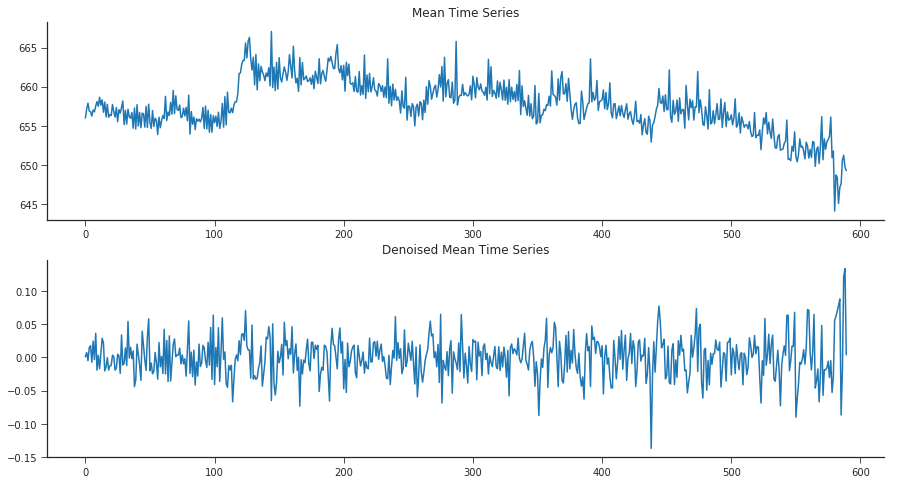

In [44]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
plt.plot(mean_ts_after)
plt.title("Mean Time Series")
fig.add_subplot(2,1,2)
plt.plot(np.average(filtered_data, axis=1))
plt.title("Denoised Mean Time Series")
sns.despine()

### ICA

In [45]:
ica= MELODIC(in_files=out_dir+'func_filtered.nii.gz',  mask=out_dir+'func_mask.nii.gz', 
             bg_image=out_dir+'func_mean_masked.nii.gz', out_dir=out_dir+'ica/',
             no_bet=True, bg_threshold=1, tr_sec=3, report=True)
ica.run()

In [46]:
! fsl_regfilt -i /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_filtered.nii.gz -d /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/ica/melodic_mix -f "1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,38,39,40" -o /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_denoised.nii.gz

### Bring LC mask in functional space
make LC mask in FSL, apply mipav transform in mipav

In [17]:
s=nb.load(out_dir+'struct/struct_avg_corrected.nii.gz')
m=nb.load(out_dir+'struct/lc_mask2struct.nii.gz')
nb.save(nb.Nifti1Image(m.get_data(), s.affine, s.header), out_dir+'struct/lc_mask2struct_fixed.nii.gz')

In [18]:
lc2func=ApplyTransforms(input_image=out_dir+'struct/lc_mask2struct_fixed.nii.gz',#'struct/lc_mask2struct.nii.gz', 
                        reference_image=out_dir+'func_mean_masked.nii.gz',
                        output_image=out_dir+'lc_mask2func.nii.gz',
                        transforms=[out_dir+'func2struct_lin_0GenericAffine.mat', 
                                    out_dir+'func2struct_nonlin_0InverseWarp.nii.gz'], 
                        invert_transform_flags=[True, False], 
                        dimension=3, interpolation='NearestNeighbor')
lc2func.run()

### Connectivity

In [47]:
conn_masker = NiftiMasker(mask_img=out_dir+'func_mask.nii.gz',smoothing_fwhm=0.2)
conn_ts = conn_masker.fit_transform(out_dir+'func_denoised.nii.gz')

In [48]:
seed_masker = NiftiMasker(mask_img=out_dir+'motor_mask.nii.gz',smoothing_fwhm=0.2)
seed_ts = seed_masker.fit_transform(out_dir+'func_denoised.nii.gz')
avg_seed_ts = np.average(seed_ts, axis=1)

In [49]:
seed_based_correlations = np.dot(conn_ts.T, avg_seed_ts) / avg_seed_ts.shape[0]
seed_based_correlations_fisher_z = np.arctanh(seed_based_correlations)

In [50]:
seed_based_correlation_img = brain_masker.inverse_transform(seed_based_correlations_fisher_z.T)
seed_based_correlation_img.to_filename(out_dir+'motor_connectivity.nii.gz')